In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoobi as scoobi

import purepyindi
from purepyindi import INDIClient
client0 = INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

Jax available; Jax model can be used.


In [2]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [57]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

# Do the normalization

In [62]:
scoobi.move_psf(-20, 0, client0)

In [63]:
reload(scoobi)
tbi.set_zwo_exp_time(0.00001, client0)

Set the ZWO exposure time to 3.20e-05s


In [65]:
reload(scoobi)
tbi.set_zwo_emgain(1, client0)

Set the ZWO gain setting to 1.0


In [64]:
reload(scoobi)
tbi.set_fib_atten(10, client)

Set the fiber attenuation to 10.0


INFO:utils:Got semaphore index 1.


34525.2


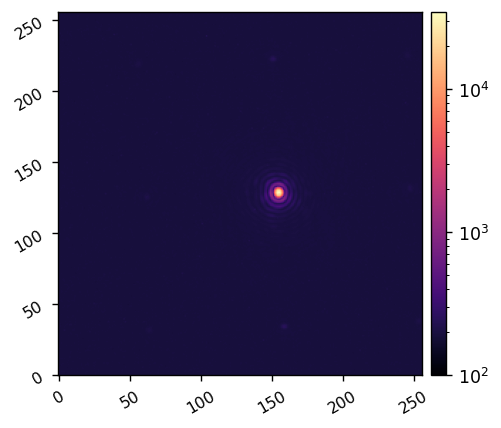

In [66]:
tbi.Nframes = 100
ref_psf = tbi.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [67]:
tbi.Imax_ref = copy.copy(xp.max(ref_psf))
tbi.texp_ref = copy.copy(tbi.texp)
tbi.att_ref = copy.copy(tbi.att)
tbi.gain_ref = copy.copy(tbi.gain)
print(tbi.Imax_ref, tbi.texp_ref, tbi.att_ref, tbi.gain_ref  )

34525.2 3.19999999192078e-05 10 1


In [87]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

tbi.Imax_ref = copy.copy(xp.max(ref_psf))
tbi.texp_ref = 3.2e-5
tbi.att_ref = 10
tbi.gain_ref = 1
print(tbi.Imax_ref, tbi.texp_ref, tbi.att_ref, tbi.gain_ref  )

34525.2 3.2e-05 10 1


In [88]:
tbi.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


In [89]:
tbi.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


In [76]:
scoobi.move_psf(-3, 0, client0)

In [97]:
tbi.set_zwo_emgain(1, client0)

Set the ZWO gain setting to 1.0


INFO:utils:Got semaphore index 1.


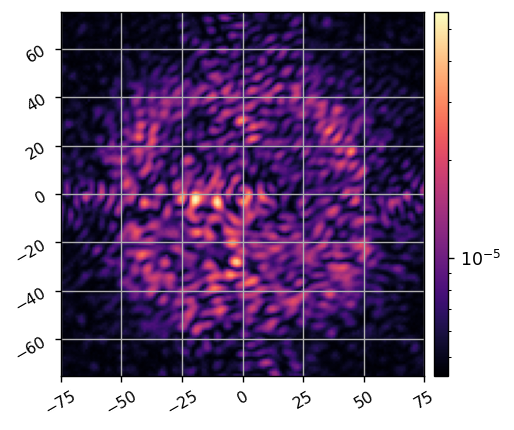

In [91]:
tbi.Nframes = 10
tbi.npsf = 150
tbi.x_shift = -5
tbi.y_shift = -4

tbi.return_ni = True

coro_im = tbi.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

# Choose modes and probes for iEFC

In [95]:
import lina

def create_control_mask(npsf, pxscl, iwa=3, owa=12, edge=None, rotation=0, centered=True):
    if centered:
        x = xp.linspace(-npsf/2, npsf/2-1, npsf)*pxscl
    else:
        x = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*pxscl
    x,y = xp.meshgrid(x,x)
    r = xp.hypot(x, y)
    control_mask = (r < owa) * (r > iwa)
    if edge is not None: control_mask *= (x > edge)

    control_mask = _scipy.ndimage.rotate(control_mask, rotation, reshape=False, order=0)
    return control_mask

control_mask = create_control_mask(tbi.npsf, tbi.psf_pixelscale_lamD, iwa=3, owa=12, edge=3,)

9.125545874986822e-06


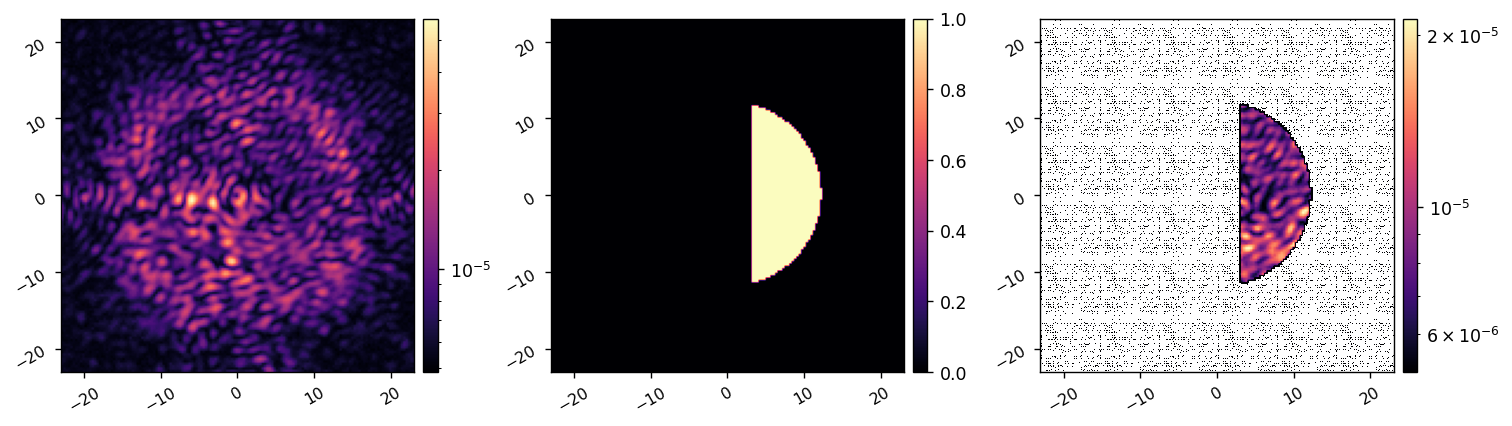

In [98]:
tbi.Nframes = 10
# ref_coro_im = tbi.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=tbi.psf_pixelscale_lamD)

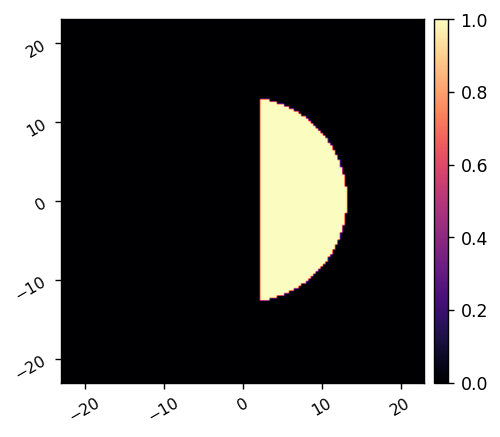

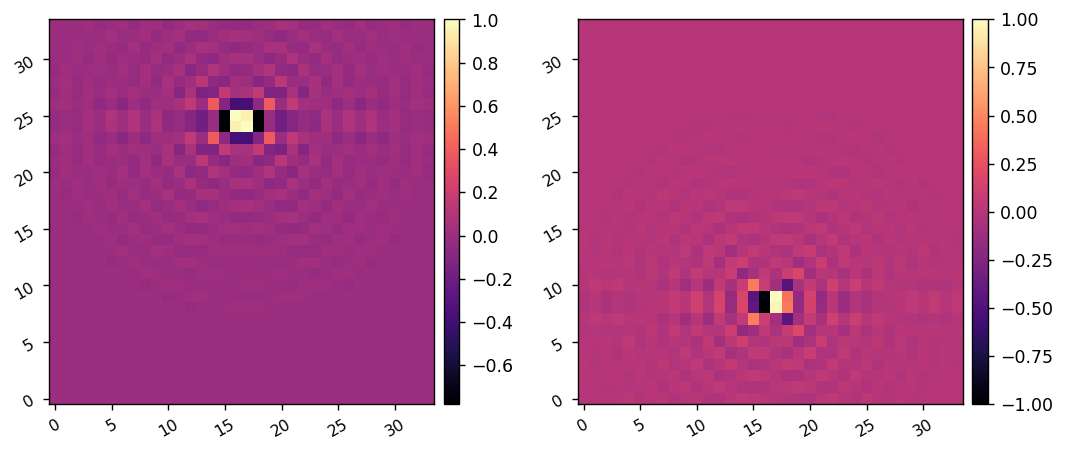

In [155]:
probe_iwa = 2
probe_owa = 13
probe_mask = create_control_mask(tbi.npsf, tbi.psf_pixelscale_lamD, probe_iwa, probe_owa, edge=2)
imshow1(probe_mask, pxscl=tbi.psf_pixelscale_lamD)
probe_modes = lina.utils.create_fourier_probes(tbi, probe_mask, fourier_sampling=0.25, 
                                               shift=[(0,8), (0,-8)], 
                                            #    shift=[(-5,6), (5,6), (0, -5)], 
                                               use_weighting=True,
                                               nprobes=2, 
                                               )
imshow2(probe_modes[0], probe_modes[1])
# imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

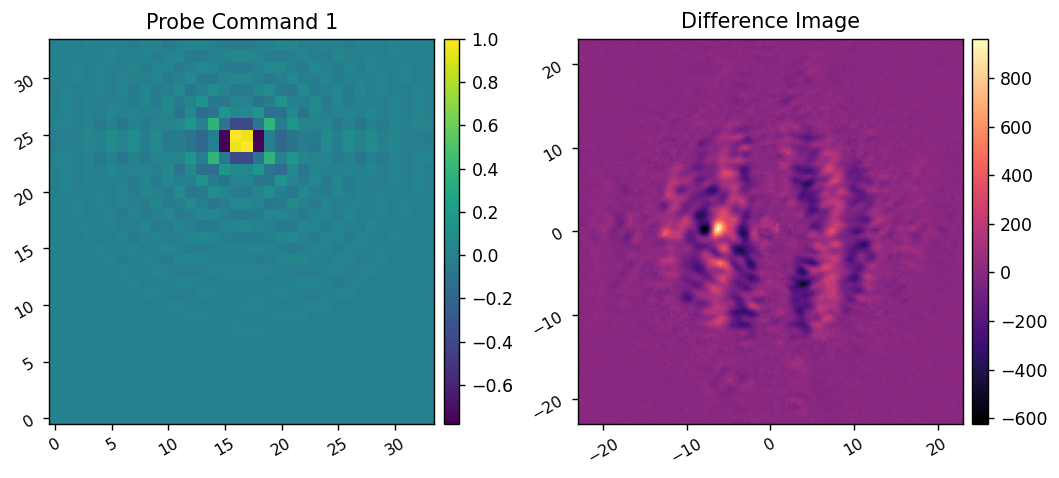

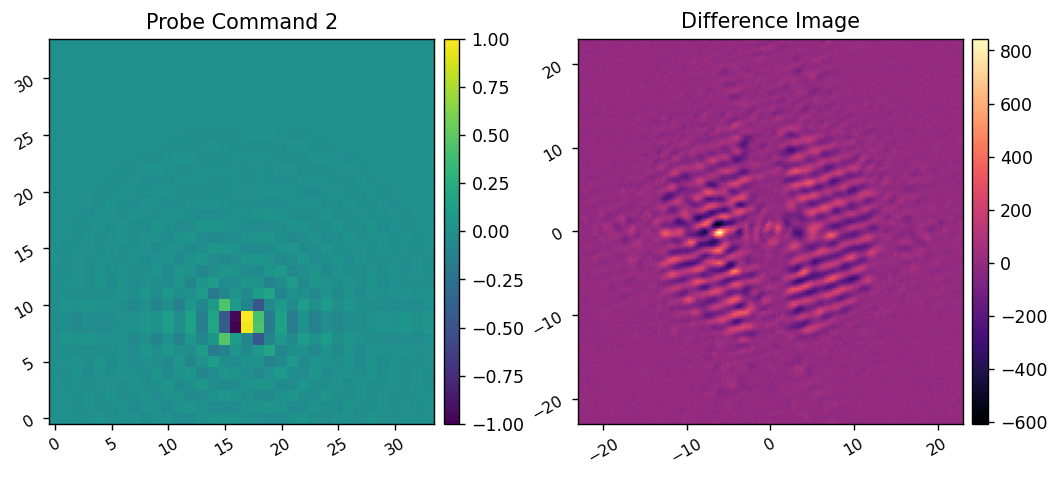

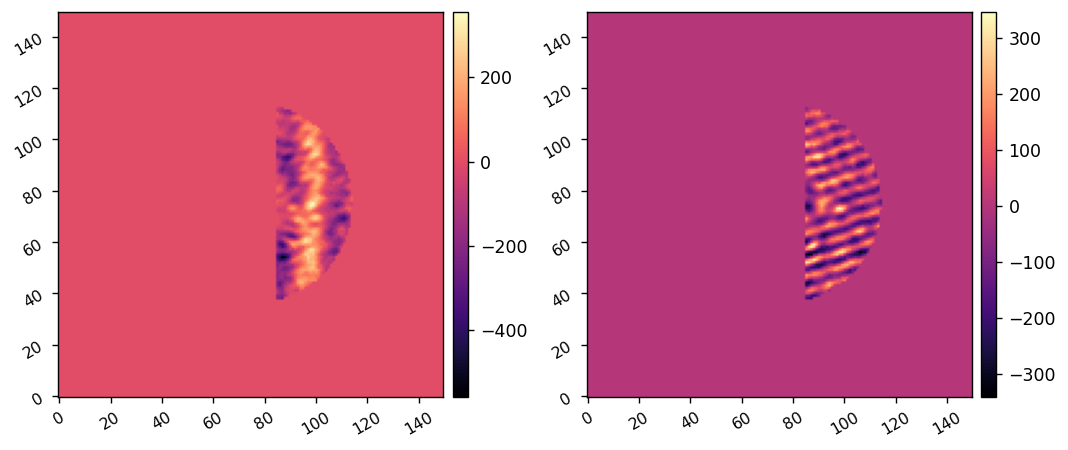

In [157]:
reload(lina.iefc)

diff_ims = lina.iefc.take_measurement(tbi, probe_modes, 5e-9, plot=True)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

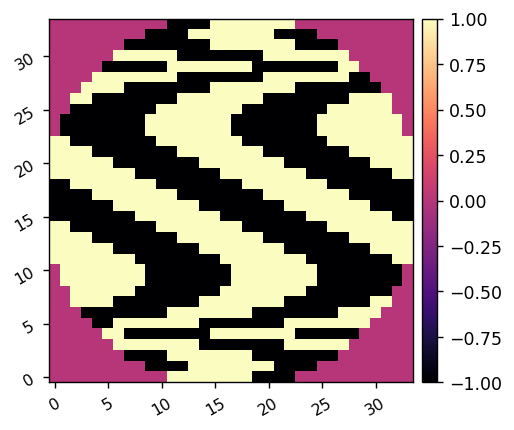

In [161]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(tbi.dm_mask))
imshow1(calib_modes[8].reshape(tbi.Nact, tbi.Nact))


In [174]:
tbi.zero_dm()

5.643150568791241e-06


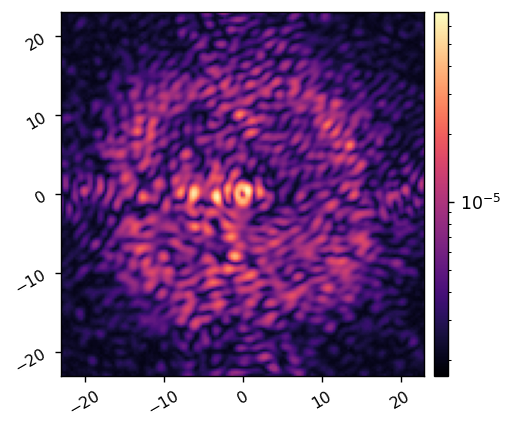

In [179]:
scoobi.set_zwo_exp_time(0.01)

tbi.texp = scoobi.get_zwo_exp_time()
tbi.Nframes = 3

coro_im = tbi.snap()
print(xp.mean(coro_im[control_mask]))
imshow1(coro_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

Calibrating iEFC...
	Calibrated mode 1024/1024 in 2424.585s
Calibration complete.


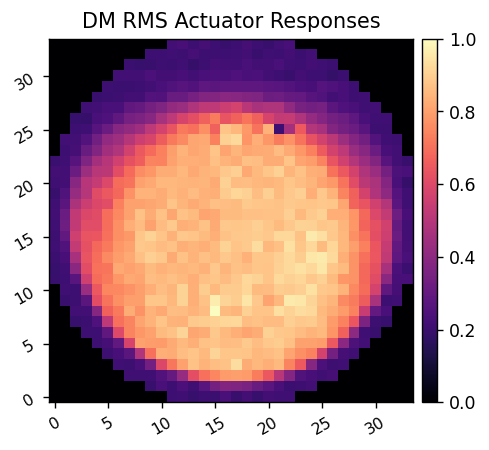

In [180]:
reload(lina.iefc)
tbi.zero_dm()

probe_amp = 5e-9
calib_amp = 5e-9

response_matrix, response_cube = lina.iefc.calibrate(tbi, control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, 
                                                     return_all=True,
                                                     )

In [181]:
lina.utils.save_fits('data/iefc_hadamard_jac.fits', response_matrix)

Saved data to:  data/iefc_hadamard_jac.fits


In [182]:
tbi.zero_dm()
all_ims = []
all_commands = []

In [200]:
scoobi.set_zwo_exp_time(0.05)

In [208]:
scoobi.client0.wait_for_properties(['scicam.emgain'])
scoobi.client0['scicam.emgain.target'] = 1

In [202]:
scoobi.client0.wait_for_properties(['scicam.emgain'])
scoobi.client0['scicam.emgain.target'] = 1
time.sleep(0.1)
im_1 = tbi.snap()

scoobi.client0.wait_for_properties(['scicam.emgain'])
scoobi.client0['scicam.emgain.target'] = 120
time.sleep(0.1)
im_120 = tbi.snap()

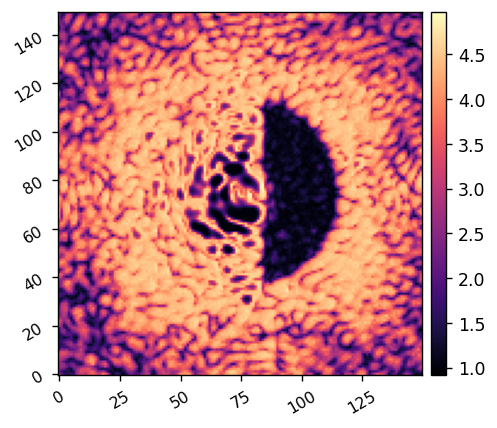

In [204]:
imshow1(im_120/im_1)

In [215]:
scoobi.set_zwo_exp_time(0.05)

4.7024196395800346e-07


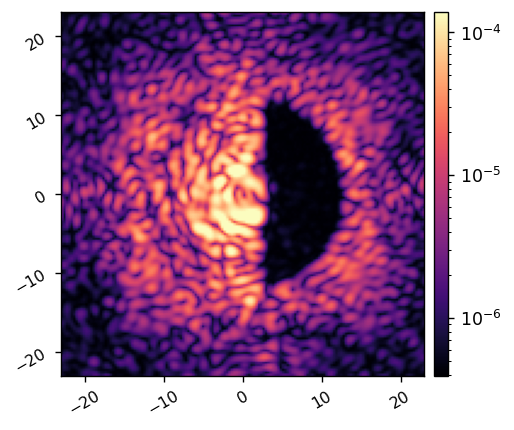

In [214]:
# scoobi.set_zwo_exp_time(0.05)

tbi.texp = scoobi.get_zwo_exp_time()
tbi.Nframes = 5

coro_im = tbi.snap()
print(xp.mean(coro_im[control_mask]))
imshow1(coro_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

Running iEFC...
	Closed-loop iteration 13 / 15


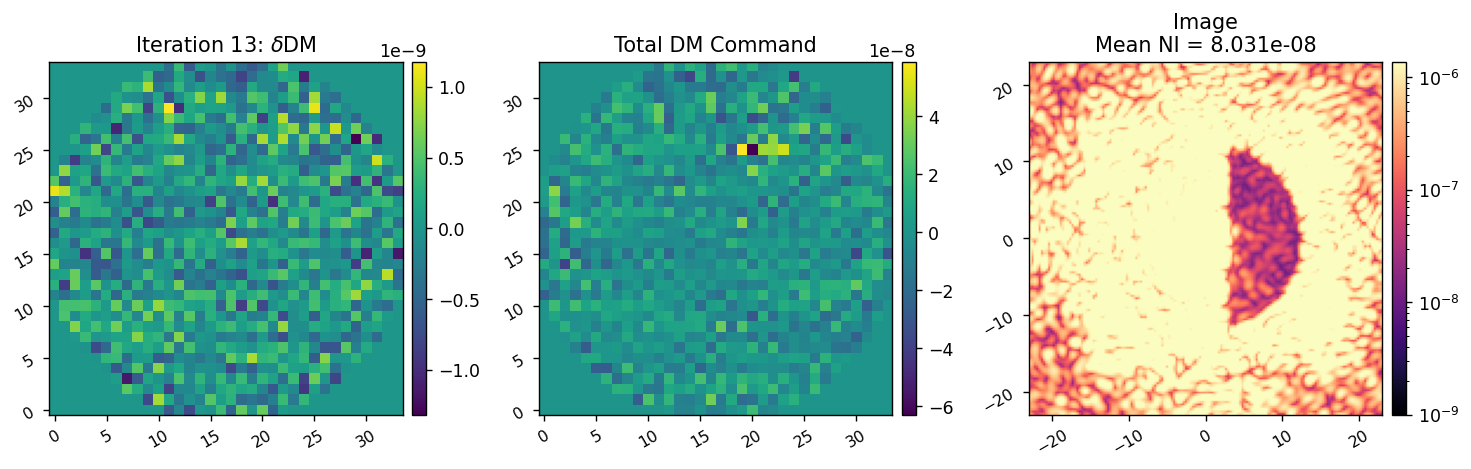

	Closed-loop iteration 14 / 15


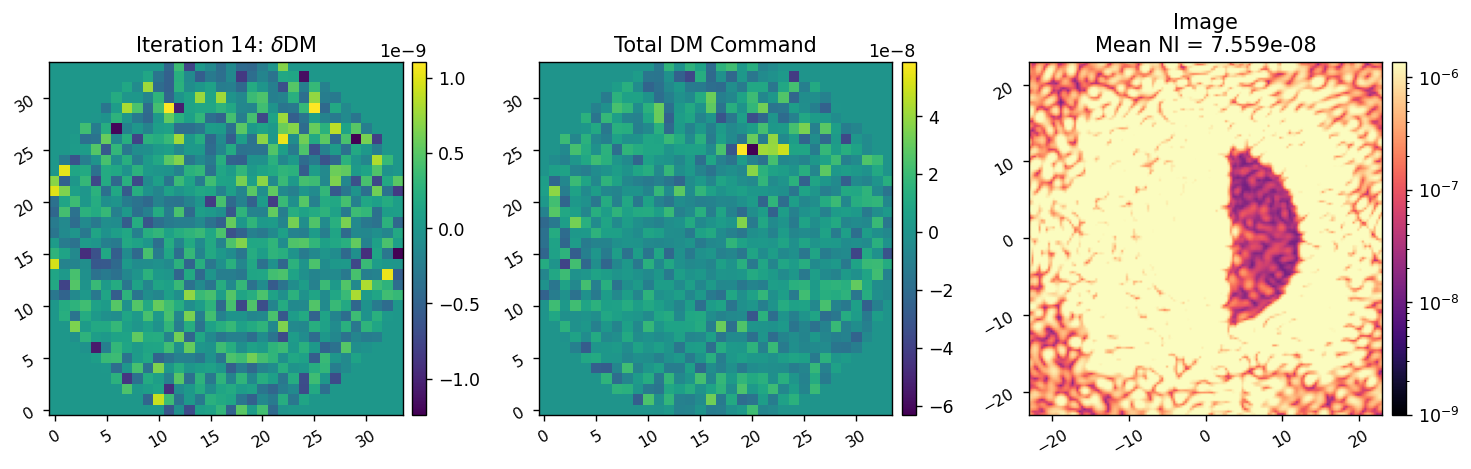

	Closed-loop iteration 15 / 15


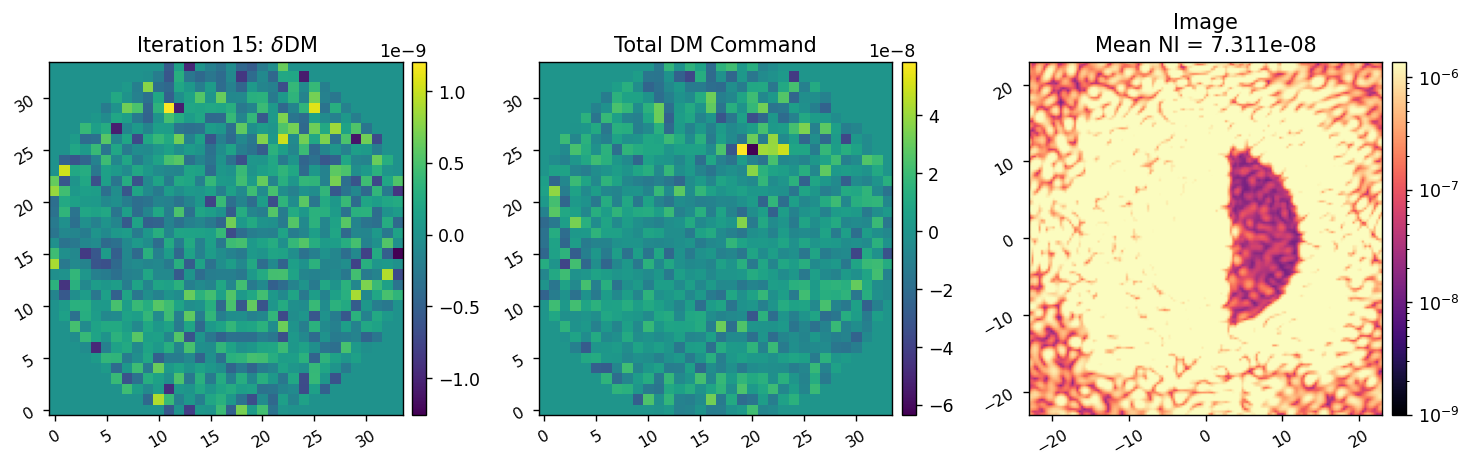

Closed loop for given control matrix completed in 153.265s.


In [198]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
# cm = lina.utils.beta_reg(response_matrix, -3.5)
# cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
probe_amp = 2.5e-9
# probe_amp = 1e-9

tbi.dm_delay = 0.5

all_ims, all_commands = lina.iefc.run(tbi,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )

Running iEFC...
	Closed-loop iteration 7 / 9


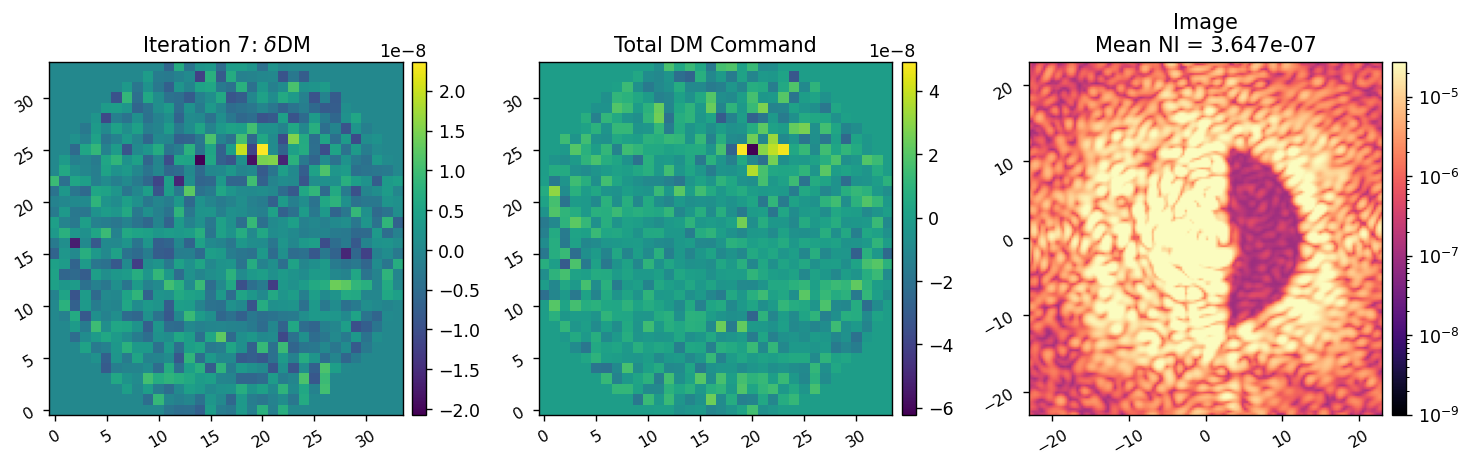

	Closed-loop iteration 8 / 9


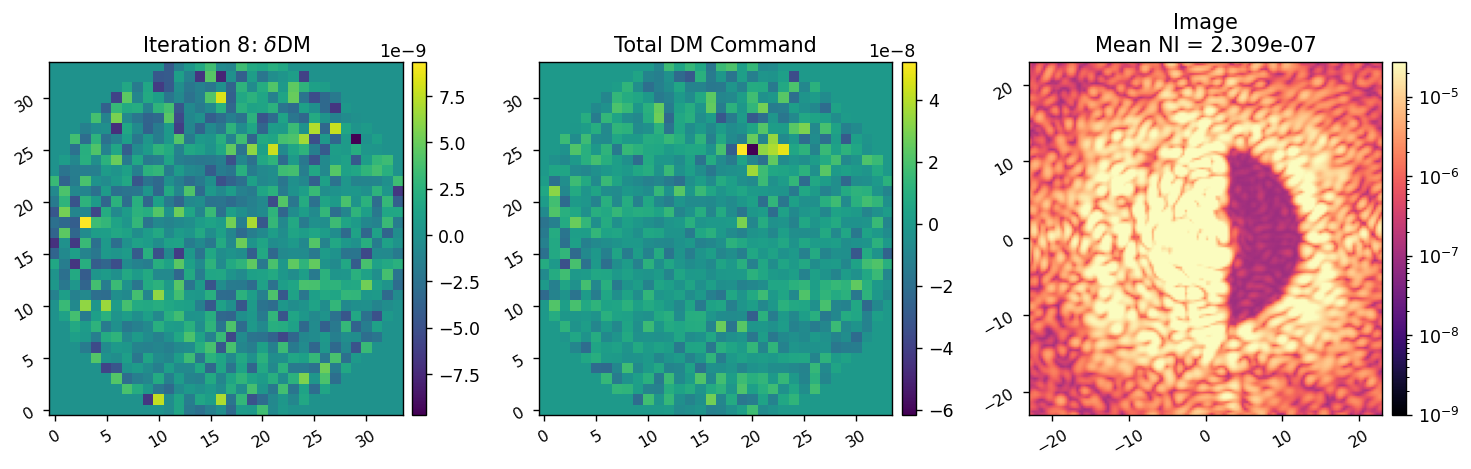

	Closed-loop iteration 9 / 9


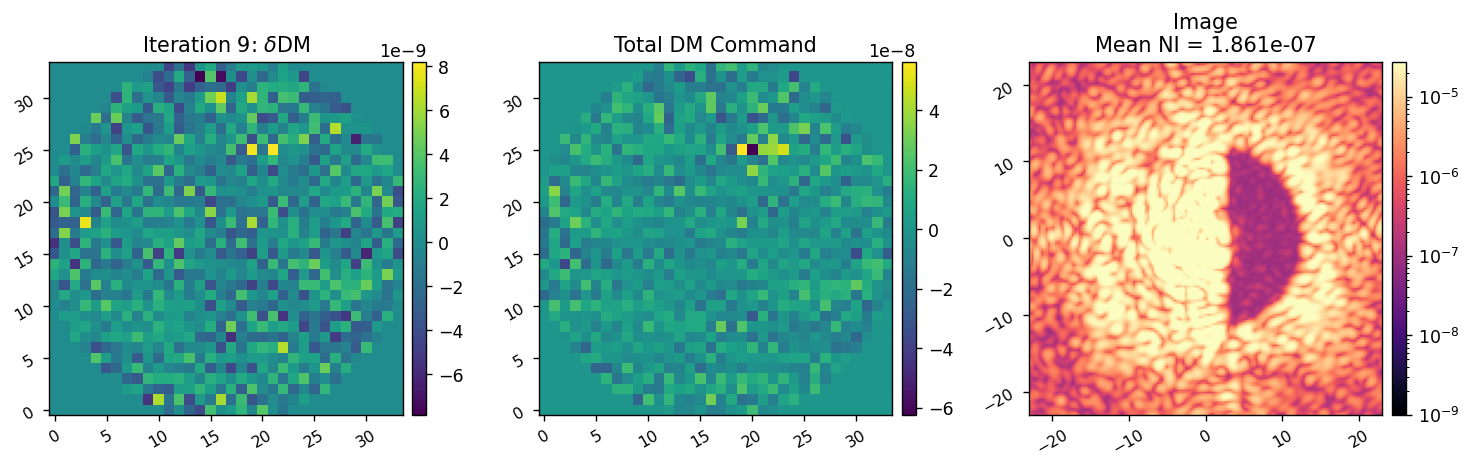

Closed loop for given control matrix completed in 86.565s.


In [192]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
probe_amp = 2.5e-9
# probe_amp = 1e-9

tbi.dm_delay = 0.5

all_ims, all_commands = lina.iefc.run(tbi,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )